In [2]:
!pip install func_timeout
#!pip install jax

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-cp37-none-any.whl size=15079 sha256=08ed82034def5c45b2ba73268d78facabd98d60256efd2a3c6cd4fedaaecbd02
  Stored in directory: /root/.cache/pip/wheels/46/7c/4f/24f1d2d5bbff92219debe7ea19af84f76ddeb90dd4ec544f26
Successfully built func-timeout


In [3]:
import numpy as np
import sys
import time
from func_timeout import func_timeout, FunctionTimedOut
import matplotlib.pyplot as plt
import math

###############################################################################
###############################################################################
###############################################################################

class geneticalgorithm():

    #############################################################
    def __init__(self, function, dimension, variable_type='bool', \
                 variable_boundaries=None,\
                 variable_type_mixed=None, \
                 function_timeout=10,\
                 algorithm_parameters={'max_num_iteration': None,\
                                       'population_size':100,\
                                       'mutation_probability':0.1,\
                                       'elit_ratio': 0.01,\
                                       'crossover_probability': 0.5,\
                                       'parents_portion': 0.3,\
                                       'crossover_type':'uniform',\
                                       'max_iteration_without_improv':None},\
                     convergence_curve=True,\
                         progress_bar=True):


        self.hist = list('')
        self.__name__=geneticalgorithm
        #############################################################
        # input function
        assert (callable(function)),"function must be callable"     
        
        self.f=function
        #############################################################
        #dimension
        
        self.dim=int(dimension)
        
        #############################################################
        # input variable type
        
        assert(variable_type=='bool' or variable_type=='int' or\
               variable_type=='real'), \
               "\n variable_type must be 'bool', 'int', or 'real'"
       #############################################################
        # input variables' type (MIXED)     

        if variable_type_mixed is None:
            
            if variable_type=='real': 
                self.var_type=np.array([['real']]*self.dim)
            else:
                self.var_type=np.array([['int']]*self.dim)            

 
        else:
            assert (type(variable_type_mixed).__module__=='numpy'),\
            "\n variable_type must be numpy array"  
            assert (len(variable_type_mixed) == self.dim), \
            "\n variable_type must have a length equal dimension."       

            for i in variable_type_mixed:
                assert (i=='real' or i=='int'),\
                "\n variable_type_mixed is either 'int' or 'real' "+\
                "ex:['int','real','real']"+\
                "\n for 'boolean' use 'int' and specify boundary as [0,1]"
                

            self.var_type=variable_type_mixed
        #############################################################
        # input variables' boundaries 

            
        if variable_type!='bool' or type(variable_type_mixed).__module__=='numpy':
                       
            assert (type(variable_boundaries).__module__=='numpy'),\
            "\n variable_boundaries must be numpy array"
        
            assert (len(variable_boundaries)==self.dim),\
            "\n variable_boundaries must have a length equal dimension"        
        
        
            for i in variable_boundaries:
                assert (len(i) == 2), \
                "\n boundary for each variable must be a tuple of length two." 
                assert(i[0]<=i[1]),\
                "\n lower_boundaries must be smaller than upper_boundaries [lower,upper]"
            self.var_bound=variable_boundaries
        else:
            self.var_bound=np.array([[0,1]]*self.dim)
 
        ############################################################# 
        #Timeout
        self.funtimeout=float(function_timeout)
        ############################################################# 
        #convergence_curve
        if convergence_curve==True:
            self.convergence_curve=True
        else:
            self.convergence_curve=False
        ############################################################# 
        #progress_bar
        if progress_bar==True:
            self.progress_bar=True
        else:
            self.progress_bar=False
        ############################################################# 
        ############################################################# 
        # input algorithm's parameters
        
        self.param=algorithm_parameters
        
        self.pop_s=int(self.param['population_size'])
        
        assert (self.param['parents_portion']<=1\
                and self.param['parents_portion']>=0),\
        "parents_portion must be in range [0,1]" 
        
        self.par_s=int(self.param['parents_portion']*self.pop_s)
        trl=self.pop_s-self.par_s
        if trl % 2 != 0:
            self.par_s+=1
               
        self.prob_mut=self.param['mutation_probability']
        
        assert (self.prob_mut<=1 and self.prob_mut>=0), \
        "mutation_probability must be in range [0,1]"
        
        
        self.prob_cross=self.param['crossover_probability']
        assert (self.prob_cross<=1 and self.prob_cross>=0), \
        "mutation_probability must be in range [0,1]"
        
        assert (self.param['elit_ratio']<=1 and self.param['elit_ratio']>=0),\
        "elit_ratio must be in range [0,1]"                
        
        trl=self.pop_s*self.param['elit_ratio']
        if trl<1 and self.param['elit_ratio']>0:
            self.num_elit=1
        else:
            self.num_elit=int(trl)
            
        assert(self.par_s>=self.num_elit), \
        "\n number of parents must be greater than number of elits"
        
        if self.param['max_num_iteration']==None:
            self.iterate=0
            for i in range (0,self.dim):
                if self.var_type[i]=='int':
                    self.iterate+=(self.var_bound[i][1]-self.var_bound[i][0])*self.dim*(100/self.pop_s)
                else:
                    self.iterate+=(self.var_bound[i][1]-self.var_bound[i][0])*50*(100/self.pop_s)
            self.iterate=int(self.iterate)
            if (self.iterate*self.pop_s)>10000000:
                self.iterate=10000000/self.pop_s
        else:
            self.iterate=int(self.param['max_num_iteration'])
        
        self.c_type=self.param['crossover_type']
        assert (self.c_type=='uniform' or self.c_type=='one_point' or\
                self.c_type=='two_point'),\
        "\n crossover_type must 'uniform', 'one_point', or 'two_point' Enter string" 
        
        
        self.stop_mniwi=False
        if self.param['max_iteration_without_improv']==None:
            self.mniwi=self.iterate+1
        else: 
            self.mniwi=int(self.param['max_iteration_without_improv'])

        
        ############################################################# 
    def run(self):
        
        
        ############################################################# 
        # Initial Population
        
        self.integers=np.where(self.var_type=='int')
        self.reals=np.where(self.var_type=='real')
        
        
        
        pop=np.array([np.zeros(self.dim+1)]*self.pop_s)
        solo=np.zeros(self.dim+1)
        var=np.zeros(self.dim)       
        
        for p in range(0,self.pop_s):
         
            for i in self.integers[0]:
                var[i]=np.random.randint(self.var_bound[i][0],\
                        self.var_bound[i][1]+1)  
                solo[i]=var[i].copy()
            for i in self.reals[0]:
                var[i]=self.var_bound[i][0]+np.random.random()*\
                (self.var_bound[i][1]-self.var_bound[i][0])    
                solo[i]=var[i].copy()


            obj=self.sim(var)            
            solo[self.dim]=obj
            pop[p]=solo.copy()

        #############################################################

        #############################################################
        # Report
        self.report=[]
        self.test_obj=obj
        self.best_variable=var.copy()
        self.best_function=obj
        ##############################################################   
                        
        t=1
        counter=0
        while t<=self.iterate:
            
            if self.progress_bar==True:
                self.progress(t,self.iterate,status="GA is running...")
            #############################################################
            #Sort
            pop = pop[pop[:,self.dim].argsort()]

                
            
            if pop[0,self.dim]<self.best_function:
                counter=0
                self.best_function=pop[0,self.dim].copy()
                self.best_variable=pop[0,: self.dim].copy()
            else:
                counter+=1
            #############################################################
            # Report

            self.report.append(pop[0,self.dim])
            self.hist.append(self.best_variable)
            ##############################################################         
            # Normalizing objective function 
            
            normobj=np.zeros(self.pop_s)
            
            minobj=pop[0,self.dim]
            if minobj<0:
                normobj=pop[:,self.dim]+abs(minobj)
                
            else:
                normobj=pop[:,self.dim].copy()
    
            maxnorm=np.amax(normobj)
            normobj=maxnorm-normobj+1

            #############################################################        
            # Calculate probability
            
            sum_normobj=np.sum(normobj)
            prob=np.zeros(self.pop_s)
            prob=normobj/sum_normobj
            cumprob=np.cumsum(prob)
  
            #############################################################        
            # Select parents
            par=np.array([np.zeros(self.dim+1)]*self.par_s)
            
            for k in range(0,self.num_elit):
                par[k]=pop[k].copy()
            for k in range(self.num_elit,self.par_s):
                index=np.searchsorted(cumprob,np.random.random())
                par[k]=pop[index].copy()
                
            ef_par_list=np.array([False]*self.par_s)
            par_count=0
            while par_count==0:
                for k in range(0,self.par_s):
                    if np.random.random()<=self.prob_cross:
                        ef_par_list[k]=True
                        par_count+=1
                 
            ef_par=par[ef_par_list].copy()
    
            #############################################################  
            #New generation
            pop=np.array([np.zeros(self.dim+1)]*self.pop_s)
            
            for k in range(0,self.par_s):
                pop[k]=par[k].copy()
                
            for k in range(self.par_s, self.pop_s, 2):
                r1=np.random.randint(0,par_count)
                r2=np.random.randint(0,par_count)
                pvar1=ef_par[r1,: self.dim].copy()
                pvar2=ef_par[r2,: self.dim].copy()
                
                ch=self.cross(pvar1,pvar2,self.c_type)
                ch1=ch[0].copy()
                ch2=ch[1].copy()
                
                ch1=self.mut(ch1)
                ch2=self.mutmidle(ch2,pvar1,pvar2)               
                solo[: self.dim]=ch1.copy()                
                obj=self.sim(ch1)
                solo[self.dim]=obj
                pop[k]=solo.copy()                
                solo[: self.dim]=ch2.copy()                
                obj=self.sim(ch2)               
                solo[self.dim]=obj
                pop[k+1]=solo.copy()
        #############################################################       
            t+=1
            if counter > self.mniwi:
                pop = pop[pop[:,self.dim].argsort()]
                if pop[0,self.dim]>=self.best_function:
                    t=self.iterate
                    if self.progress_bar==True:
                        self.progress(t,self.iterate,status="GA is running...")
                    time.sleep(2)
                    t+=1
                    self.stop_mniwi=True
                
        #############################################################
        #Sort
        pop = pop[pop[:,self.dim].argsort()]
        
        if pop[0,self.dim]<self.best_function:
                
            self.best_function=pop[0,self.dim].copy()
            self.best_variable=pop[0,: self.dim].copy()
        #############################################################
        # Report

        self.report.append(pop[0,self.dim])
        
 
        
        self.output_dict={'variable': self.best_variable, 'function':\
                          self.best_function}
        if self.progress_bar==True:
            show=' '*100
            sys.stdout.write('\r%s' % (show))
        sys.stdout.write('\r The best solution found:\n %s' % (self.best_variable))
        sys.stdout.write('\n\n Objective function:\n %s\n' % (self.best_function))
        sys.stdout.flush() 
        re=np.array(self.report)
        if self.convergence_curve==True:
            plt.plot(re)
            plt.xlabel('Iteration')
            plt.ylabel('Objective function')
            plt.title('Genetic Algorithm')
            plt.show()
        
        if self.stop_mniwi==True:
            sys.stdout.write('\nWarning: GA is terminated due to the'+\
                             ' maximum number of iterations without improvement was met!')
##############################################################################         
##############################################################################         
    def cross(self,x,y,c_type):
         
        ofs1=x.copy()
        ofs2=y.copy()
        

        if c_type=='one_point':
            ran=np.random.randint(0,self.dim)
            for i in range(0,ran):
                ofs1[i]=y[i].copy()
                ofs2[i]=x[i].copy()
  
        if c_type=='two_point':
                
            ran1=np.random.randint(0,self.dim)
            ran2=np.random.randint(ran1,self.dim)
                
            for i in range(ran1,ran2):
                ofs1[i]=y[i].copy()
                ofs2[i]=x[i].copy()
            
        if c_type=='uniform':
                
            for i in range(0, self.dim):
                ran=np.random.random()
                if ran <0.5:
                    ofs1[i]=y[i].copy()
                    ofs2[i]=x[i].copy() 
                   
        return np.array([ofs1,ofs2])
###############################################################################  
    
    def mut(self,x):
        
        for i in self.integers[0]:
            ran=np.random.random()
            if ran < self.prob_mut:
                
                x[i]=np.random.randint(self.var_bound[i][0],\
                 self.var_bound[i][1]+1) 
                    
        

        for i in self.reals[0]:                
            ran=np.random.random()
            if ran < self.prob_mut:   

               x[i]=self.var_bound[i][0]+np.random.random()*\
                (self.var_bound[i][1]-self.var_bound[i][0])    
            
        return x
###############################################################################
    def mutmidle(self, x, p1, p2):
        for i in self.integers[0]:
            ran=np.random.random()
            if ran < self.prob_mut:
                if p1[i]<p2[i]:
                    x[i]=np.random.randint(p1[i],p2[i])
                elif p1[i]>p2[i]:
                    x[i]=np.random.randint(p2[i],p1[i])
                else:
                    x[i]=np.random.randint(self.var_bound[i][0],\
                 self.var_bound[i][1]+1)
                        
        for i in self.reals[0]:                
            ran=np.random.random()
            if ran < self.prob_mut:   
                if p1[i]<p2[i]:
                    x[i]=p1[i]+np.random.random()*(p2[i]-p1[i])  
                elif p1[i]>p2[i]:
                    x[i]=p2[i]+np.random.random()*(p1[i]-p2[i])
                else:
                    x[i]=self.var_bound[i][0]+np.random.random()*\
                (self.var_bound[i][1]-self.var_bound[i][0]) 
        return x
###############################################################################     
    def evaluate(self):
        return self.f(self.temp)
###############################################################################    
    def sim(self,X):
        self.temp=X.copy()
        obj=None
        try:
            obj=func_timeout(self.funtimeout,self.evaluate)
        except FunctionTimedOut:
            print("given function is not applicable")
        assert (obj!=None), "After "+str(self.funtimeout)+" seconds delay "+\
                "func_timeout: the given function does not provide any output"
        return obj

###############################################################################
    def progress(self, count, total, status=''):
        bar_len = 50
        filled_len = int(round(bar_len * count / float(total)))

        percents = round(100.0 * count / float(total), 1)
        bar = '|' * filled_len + '_' * (bar_len - filled_len)

        sys.stdout.write('\r%s %s%s %s' % (bar, percents, '%', status))
        sys.stdout.flush()     
###############################################################################            
###############################################################################

In [4]:
H = 0.2
density = 2000 * (0.005*0.02) #Link Material(Carbon Fiber) Density (kg/m)
g = 9.81                      #gravitational acceleration (m/s2)

In [5]:
#@jit
def kinematic(omega1,alpha1,N,L,R,theta):

    global H

    is_singular = False

    ######## Analytic Solution Calculated With Maple ########
    phi = math.atan2((-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) - H * (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) * math.sqrt(2) / 4 + N * (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) * math.cos(theta) / 2 + H ** 2 + L ** 2 + N ** 2 - R ** 2) / L / (H * math.sqrt(2) - 2 * N * math.sin(theta)), (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) / L / 4)
    psi = math.atan2((-2 * N ** 2 * math.sin(theta) ** 2 * math.sqrt(2) + N * math.sqrt(2) * (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) * math.cos(theta) / 2 + 2 * H * N * math.sin(theta) - 2 * H * N * math.cos(theta) + L ** 2 * math.sqrt(2) + N ** 2 * math.sqrt(2) - R ** 2 * math.sqrt(2) - H * (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) / 2) / R / (H - math.sqrt(2) * N * math.sin(theta)), -(H * math.sqrt(2) - 2 * N * math.cos(theta) - (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) / 2) / R)


    b = np.array([[-L*np.sin(phi),R*np.sin(psi)],
                  [L*np.cos(phi),-R*np.cos(psi)]])
    if np.linalg.det(b) == 0:
        is_singular = True
        phi,psi,omega2,omega3,alpha2,alpha3 = [0,0,0,0,0,0]

    else:   
        first = np.array([N*np.sin(theta),-N*np.cos(theta)])
        first_order = np.dot(first,np.linalg.inv(b))
        second = np.array([N*np.cos(theta) + L*first_order[0]**2*np.cos(phi) - R*first_order[1]**2*np.cos(psi),
                        N*np.sin(theta) + L*first_order[0]**2*np.sin(phi) - R*first_order[1]**2*np.sin(psi)])
        second_order = np.dot(np.linalg.inv(b),second)

        omega2 = first_order[0] * omega1
        omega3 = first_order[1] * omega1

        alpha2 = alpha1 * first_order[0] + omega1**2 * second_order[0]
        alpha3 = alpha1 * first_order[1] + omega1 ** 2 * second_order[1]

    return phi,psi,omega2,omega3,alpha2,alpha3,is_singular

In [6]:
#@jit
def kinetic(N,L,R,theta,phi,psi,omega1,omega2,omega3,alpha1,alpha2,alpha3,tau1):

    global density
    global g
    global H

    m1 = density * H        # Shanks mass (Link N)
    m2 = density * L        # Link L mass
    m3 = density * R        # link R mass
    r1 = 0.2                # Shanks Center of mass

    #inertial moments (approximated)
    I1 = m1 * H**2 / 12
    I2 = m2 * L**2 / 12
    I3 = m3 * R**2 / 12

    A = np.array([N*np.cos(theta),N*np.sin(theta)])

    # CoM Position of Links
    CN = np.array([r1 * np.cos(theta+np.pi),
                  r1 * np.sin(theta+np.pi)])
    CL = np.array([L/2 * np.cos(phi),
                  L/2 * np.sin(phi)])
    CR = np.array([R/2 * np.cos(psi),
                  R/2 * np.sin(psi)])
    # CoM Acceleration of Links
    aN = np.array([-alpha1 * CN[1] - omega1**2 * CN[0],
                  alpha1 * CN[0] - omega1**2 * CN[1]])
    aL = np.array([-alpha1*A[1] - omega1**2*A[0] - alpha2*CL[1] - omega2**2*CL[0],
                  alpha1*A[0] - omega1**2*A[1] + alpha2*CL[0] - omega2**2*CL[1]])
    aR = np.array([-alpha3*CR[1] - omega3**2*CR[0],
                  alpha3*CR[0] - omega3**2*CR[1]])

    F1 = np.array([m1*aN[0],m1*aN[1]])
    F2 = np.array([m2*aL[0],m2*aL[1]])
    F3 = np.array([m3*aR[0],m3*aR[1]])

    M1 = I1 * alpha1
    M2 = I2 * alpha2
    M3 = I3 * alpha3

    A = np.array([[1,0,-1,0,0,0,0,0,0],
                  [0,-1,0,1,0,0,0,0,0],
                  [-N*np.sin(theta-np.pi),N*np.cos(theta-np.pi),0,0,0,0,0,0,0],
                  [1,0,0,0,-1,0,0,0,0],
                  [0,1,0,0,0,-1,0,0,0],
                  [0,0,0,0,-L*np.sin(phi),-L*np.cos(phi),0,0,0],
                  [0,0,0,0,-1,0,1,0,0],
                  [0,0,0,0,0,1,0,-1,0],
                  [0,0,0,0,R*np.sin(psi),R*np.cos(psi),0,0,1]])
    B = np.array([F1[0],
                  F1[1]+m1*g,
                  M1+m1*g*CN[0]+np.linalg.norm(np.cross(CN,F1))+tau1,
                  -F2[0],
                  F2[1]+m2*g,
                  M2+m2*g*CL[0]+np.linalg.norm(np.cross(CL,F2)),
                  F3[0],
                  F3[1]+m3*g,
                  M3+m3*g*CR[0]+np.linalg.norm(np.cross(CR,F3))])

    return np.linalg.solve(A,B)[8],omega3*np.linalg.solve(A,B)[8]

 The best solution found:
 [0.09892446 0.22575822 0.05326521]

 Objective function:
 931.7533449473441


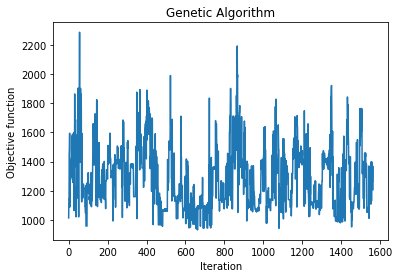

In [7]:
def cost_fcn(x):
    N = x[0]
    L = x[1]
    R = x[2]
    omega = 10 * np.pi /30      # constant angular velocity @ 10rpm
    alpha = 0

    power = list("")
    torque = list("")

    for theta in range(105, 170):
        tau = 0.2 * np.cos(np.pi - theta) * 1.5 * g    # 1.5kg of payload @ pelvis
        #tau = 0  # Zero payload
        try:
            phi, psi, omega2, omega3, alpha2, alpha3, s = kinematic(omega, alpha, N, L, R, theta * np.pi / 180)
        except:
            return 2500 # Singular solutions are not valid
        torque.append(kinetic(N, L, R, theta * np.pi / 180, phi, psi, omega, omega2, omega3,
                              alpha, alpha2, alpha3, tau)[0])
        power.append(kinetic(N, L, R, theta * np.pi / 180, phi, psi, omega, omega2, omega3,
                              alpha, alpha2, alpha3, tau)[0])

    power = np.array(power)
    power = np.sum(np.abs(power))
    torque = np.array(torque)
    torque = np.sum(np.abs(torque))
    return torque + power
 
 
var_bound=np.array([[0.05,0.1],
                    [0.15,0.25],
                    [0.05,0.15]])
 
algorithm_param = {'max_num_iteration': 5000,
                    'population_size':180,
                    'mutation_probability':0.09,
                    'elit_ratio': 0.0,
                    'crossover_probability': 0.5,
                    'parents_portion': 0.4,
                    'crossover_type':'uniform',
                    'max_iteration_without_improv':900}
 
model=geneticalgorithm(function=cost_fcn,dimension=3,variable_type='real',
            variable_boundaries=var_bound,
            algorithm_parameters=algorithm_param,
            convergence_curve=True, progress_bar=True,function_timeout=30)
model.run()

In [8]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Mech/Ihsan/Knee Mechanism

Mounted at /content/drive
/content/drive/My Drive/Mech/Ihsan/Knee Mechanism


In [101]:
import pandas as pd
hist = np.array(model.hist)

df = pd.DataFrame (hist)

df.to_excel('/content/drive/My Drive/Mech/Ihsan/Knee Mechanismlink.xlsx', index=False)

print(hist)

[[0.09369044 0.21530319 0.05252215]
 [0.09369044 0.21530319 0.05252215]
 [0.09369044 0.21530319 0.05252215]
 ...
 [0.09892446 0.22575822 0.05326521]
 [0.09892446 0.22575822 0.05326521]
 [0.09892446 0.22575822 0.05326521]]


In [68]:
%pwd
%ls

4_bar_ga.py               animate_ga.ipynb  knee_joint.bin  link.xlsx
4-bar_optimization.ipynb  GA_progress.mp4   knee_test.bin   sketch.SLDPRT


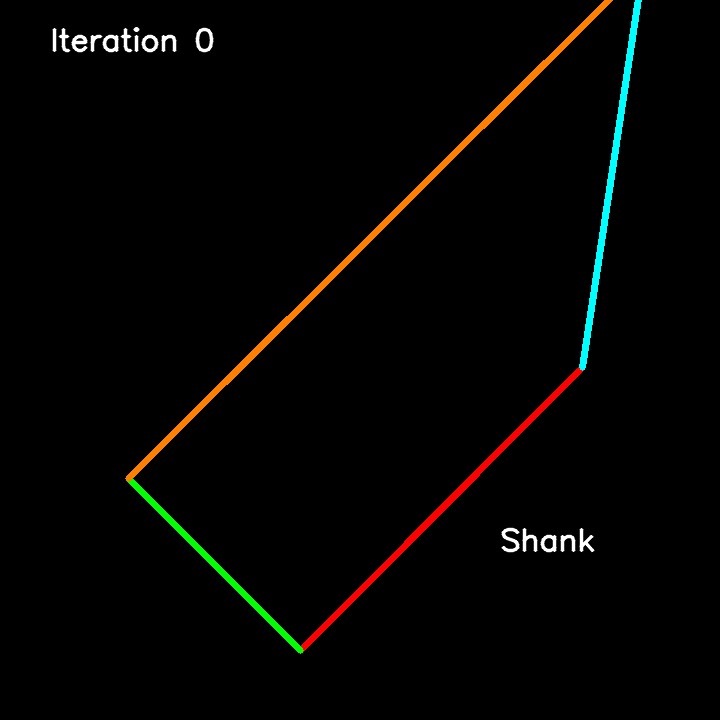

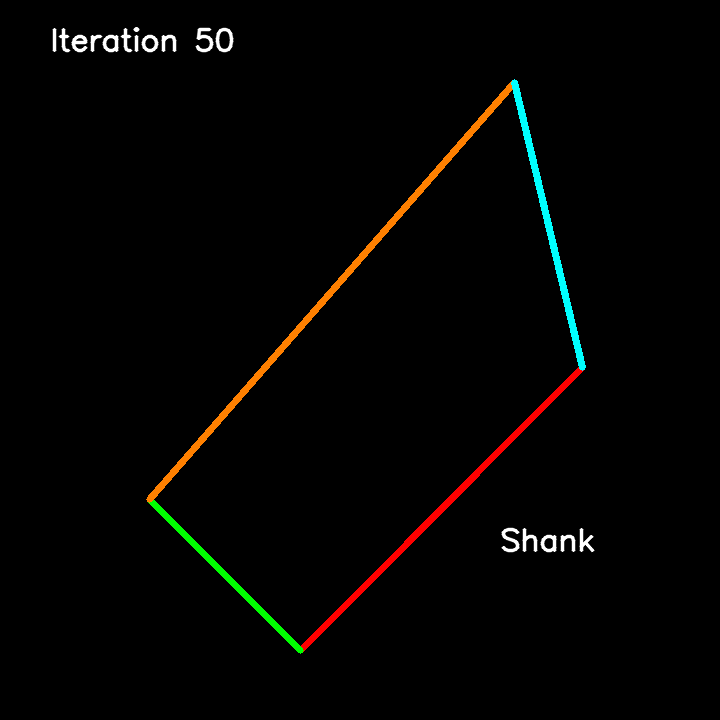

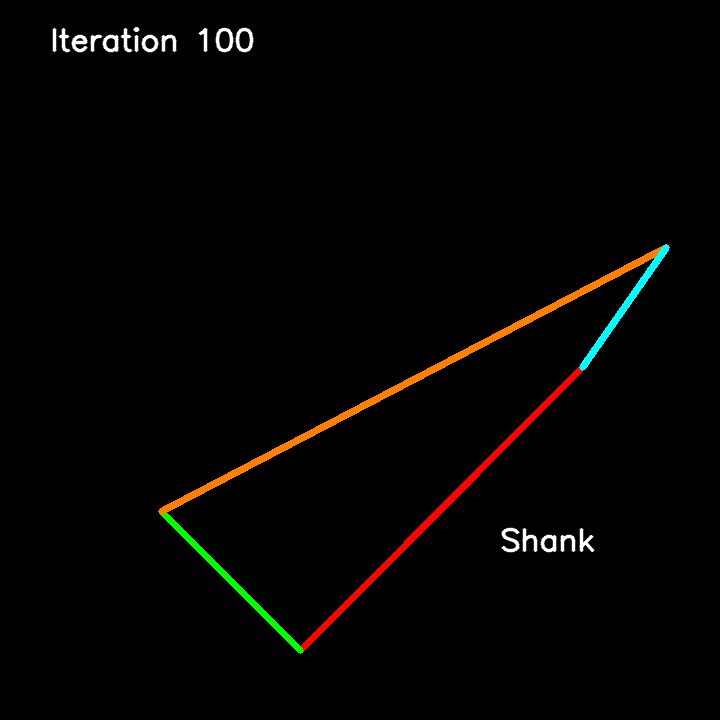

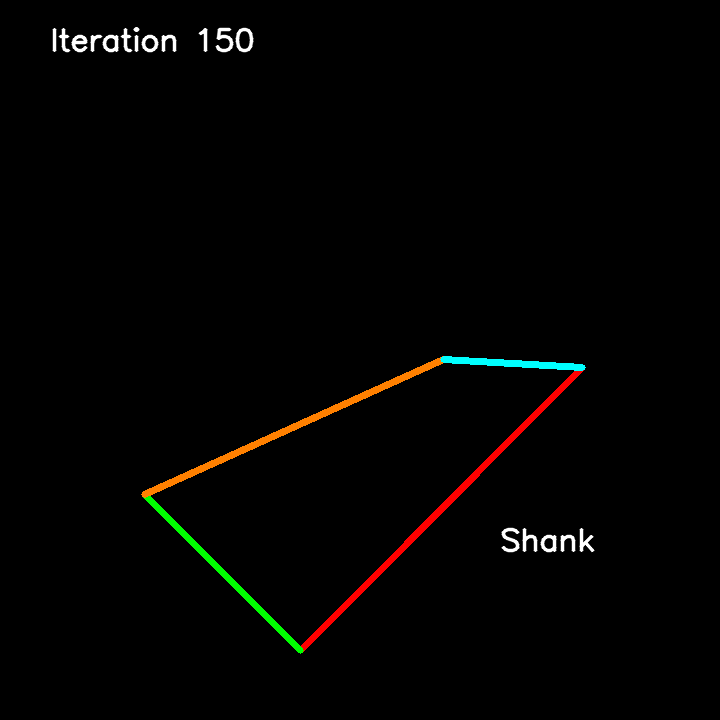

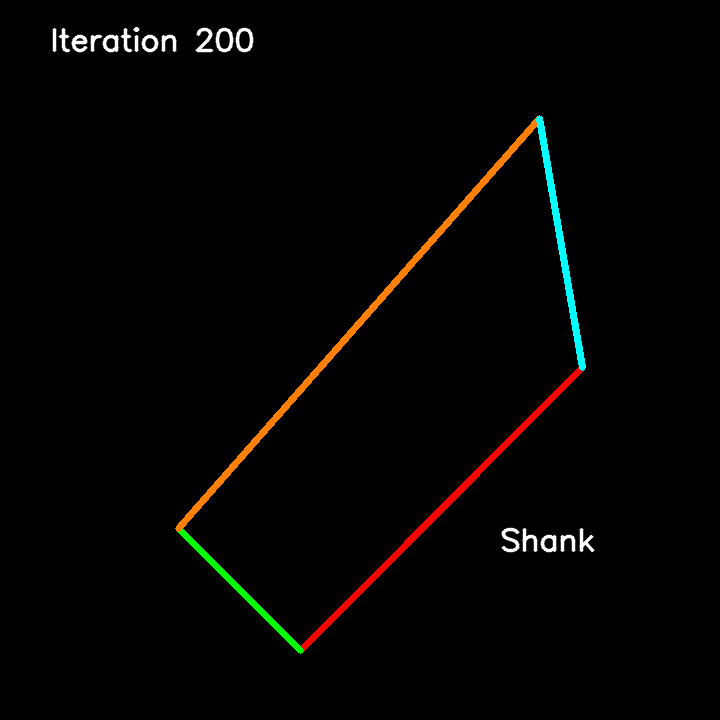

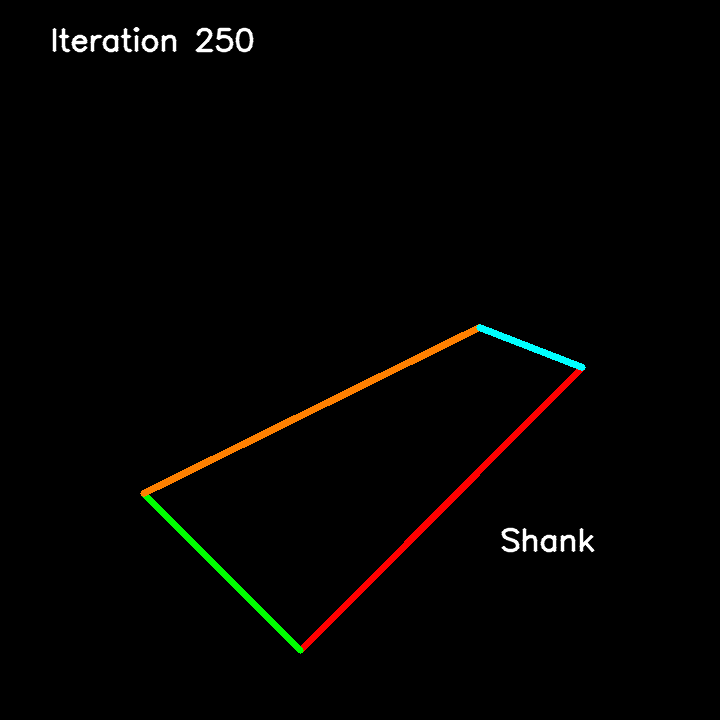

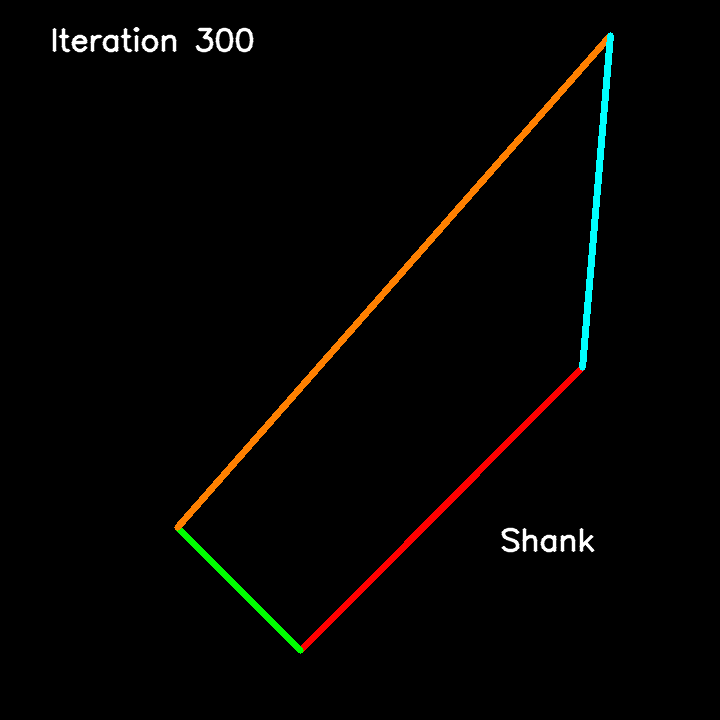

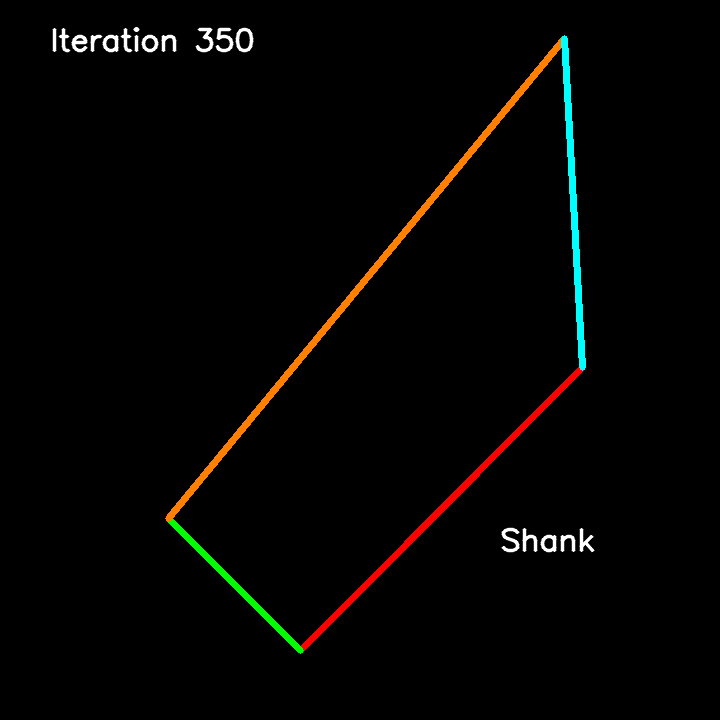

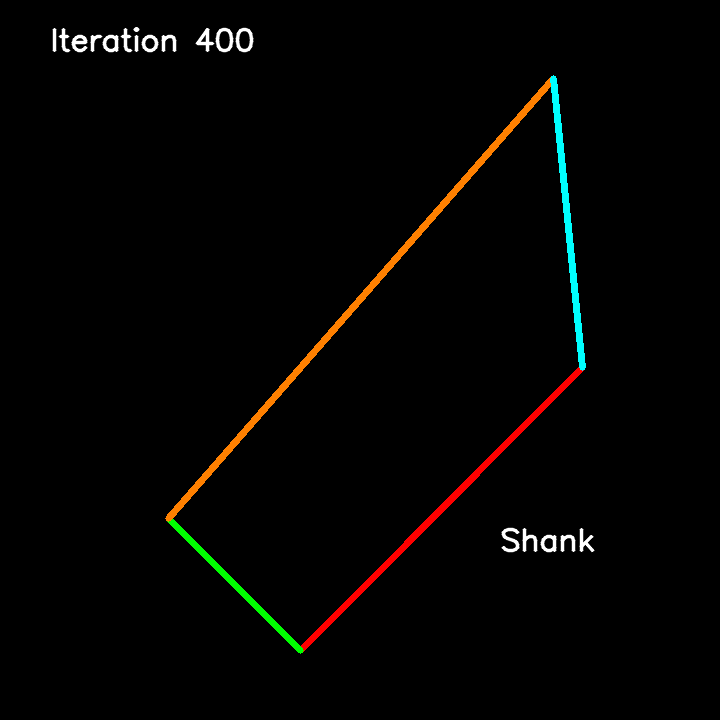

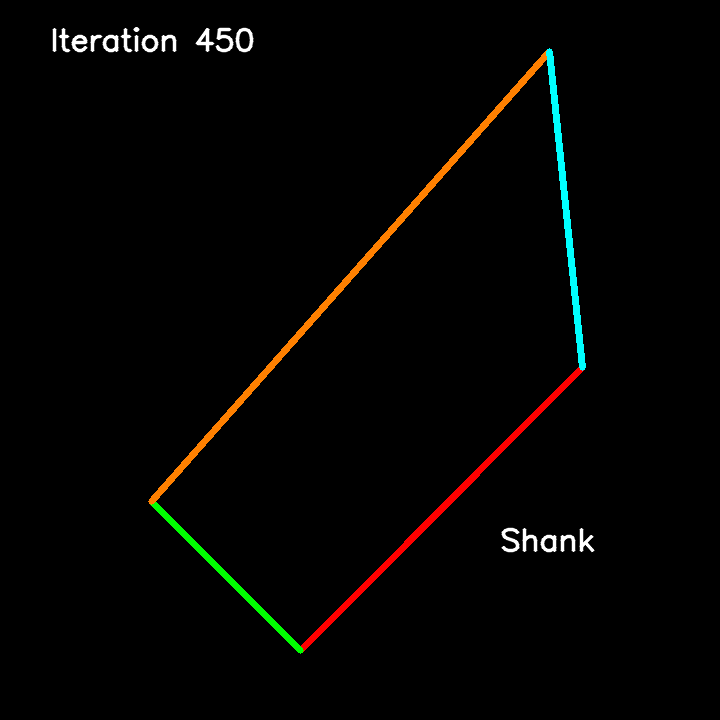

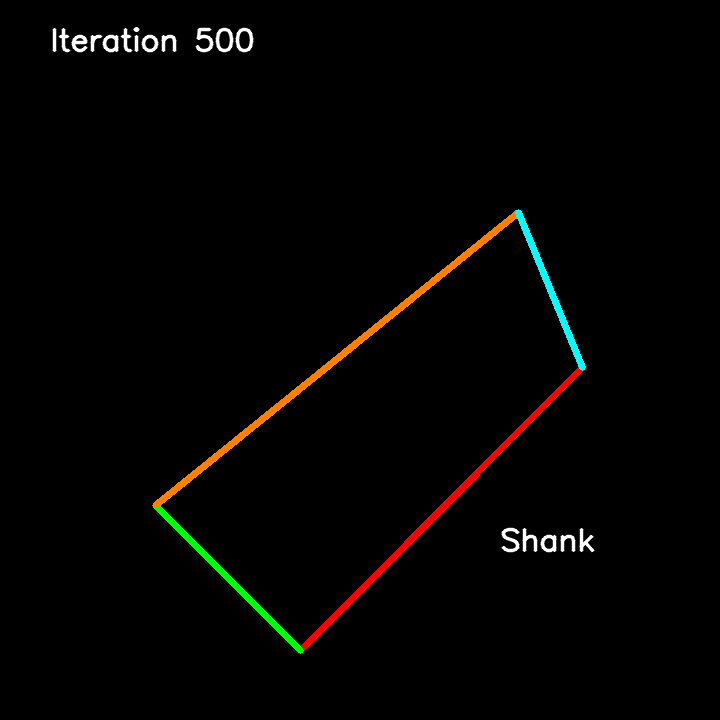

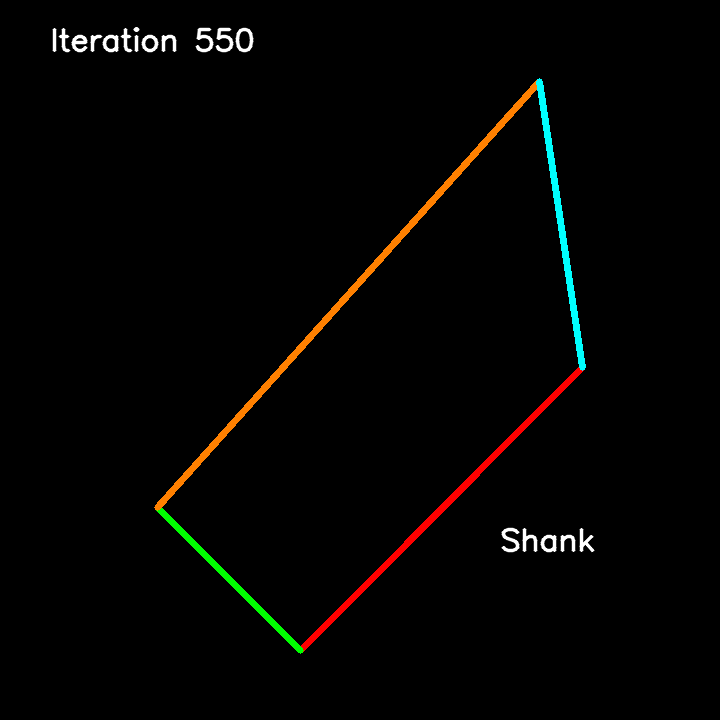

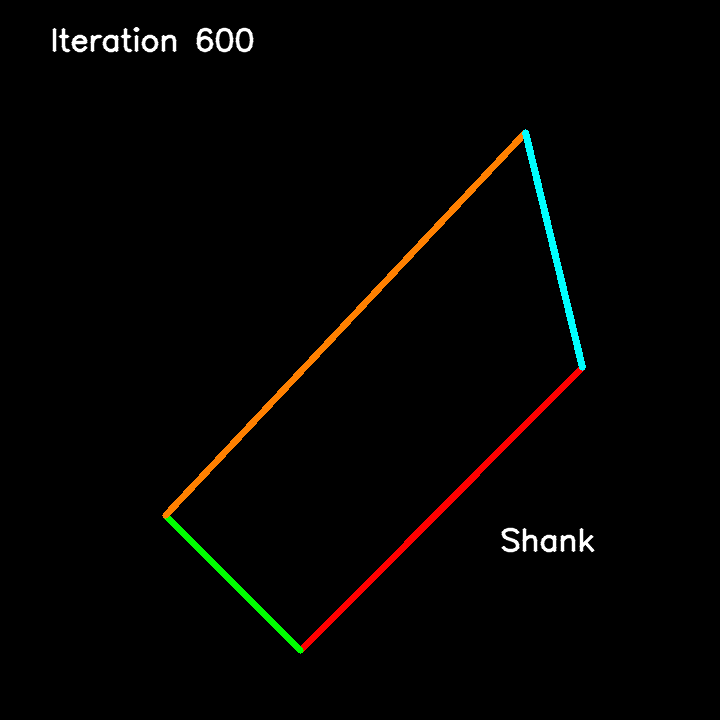

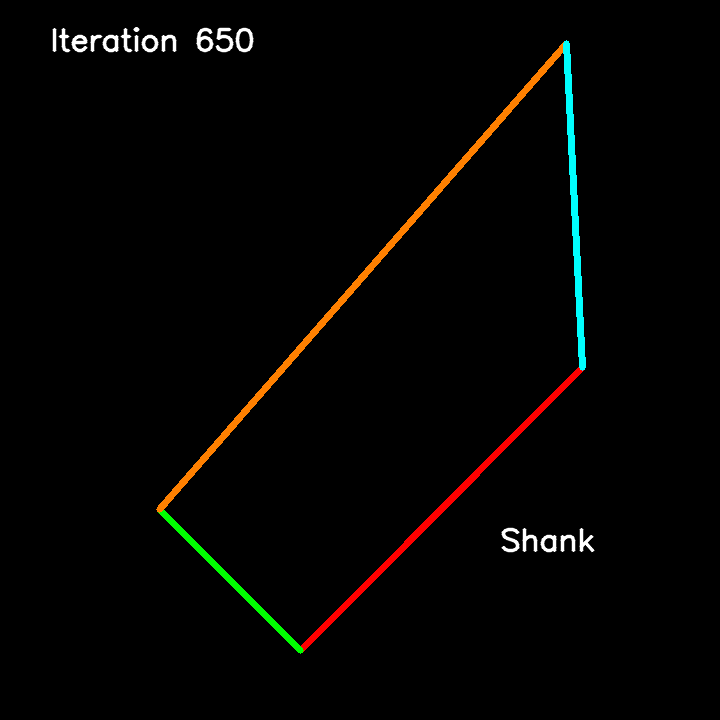

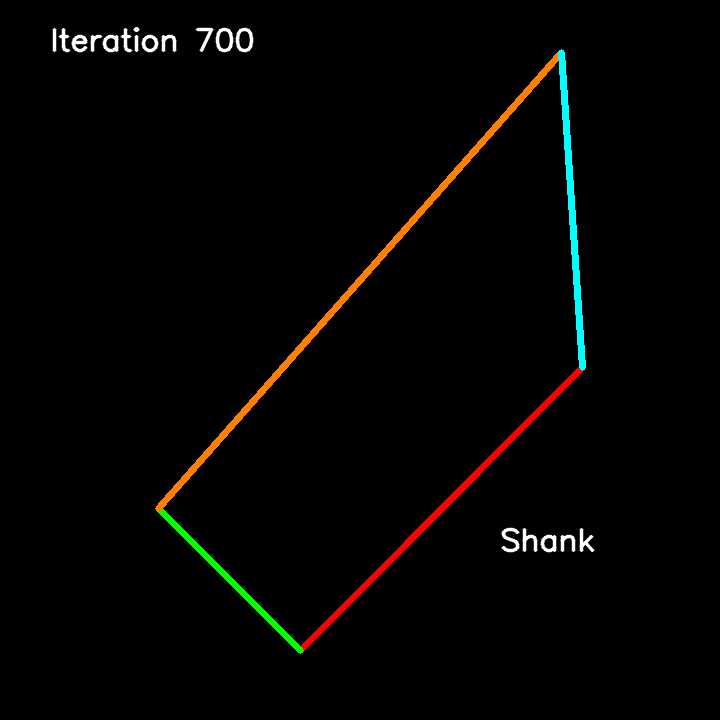

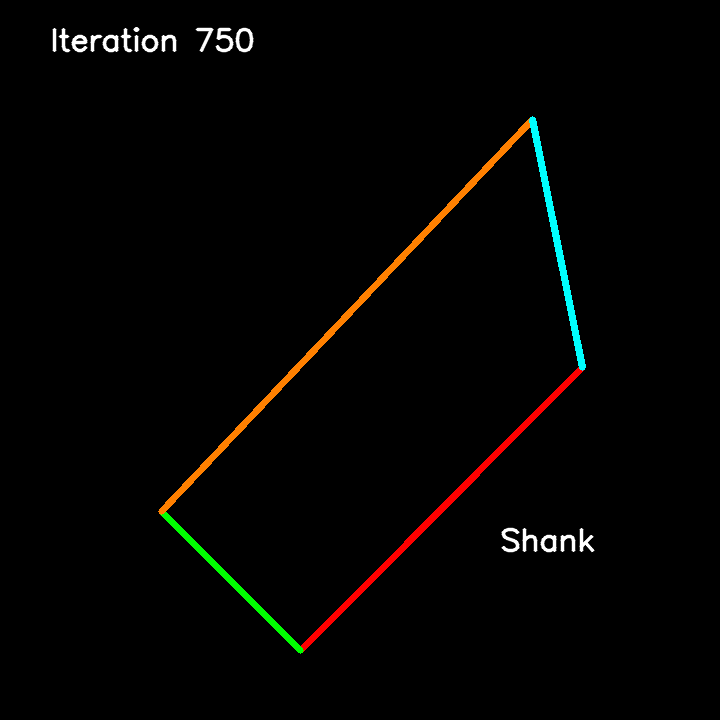

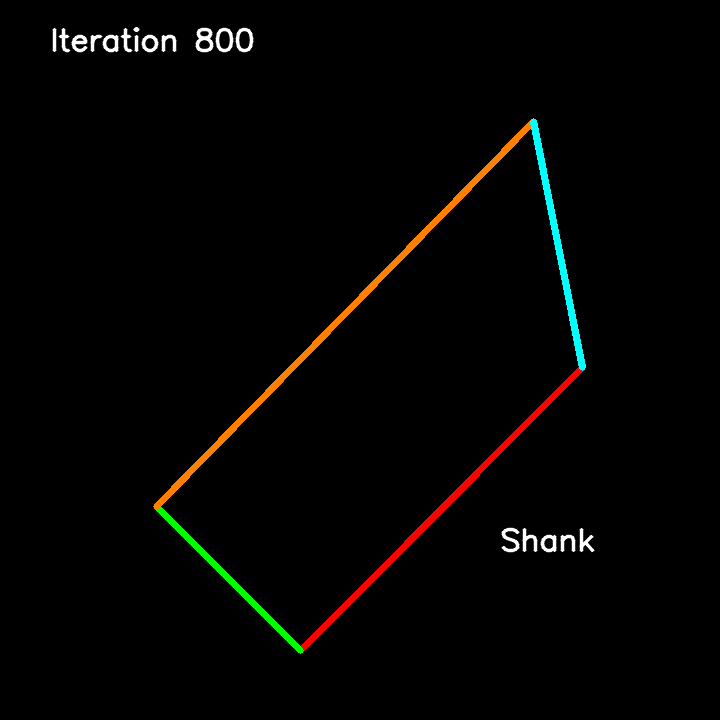

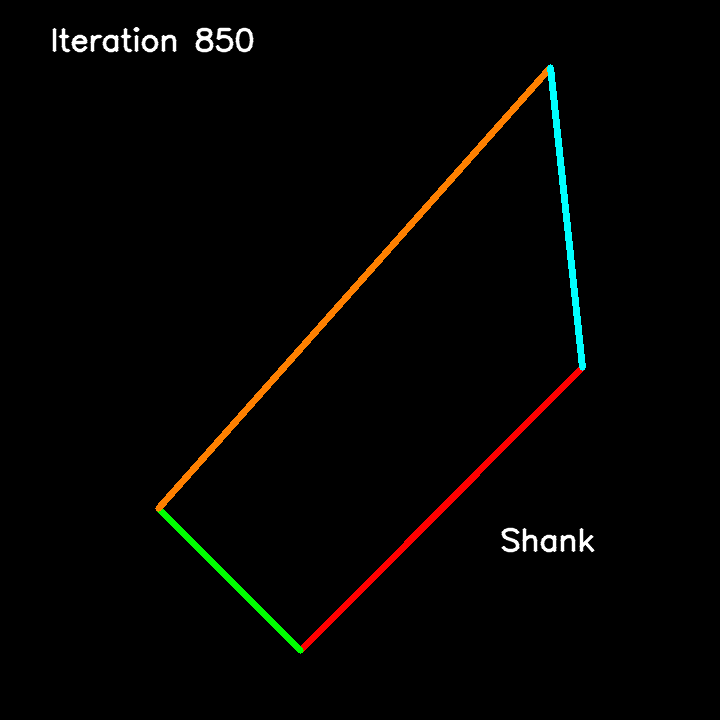

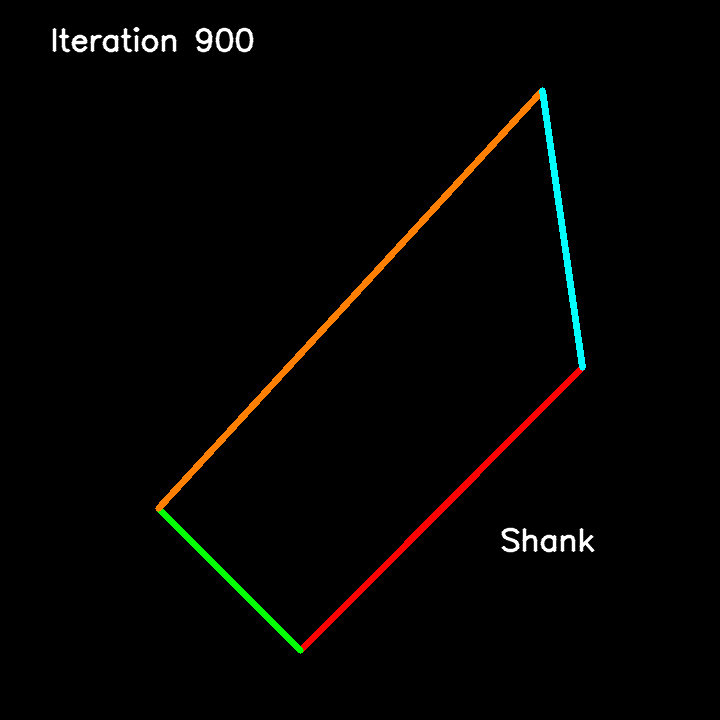

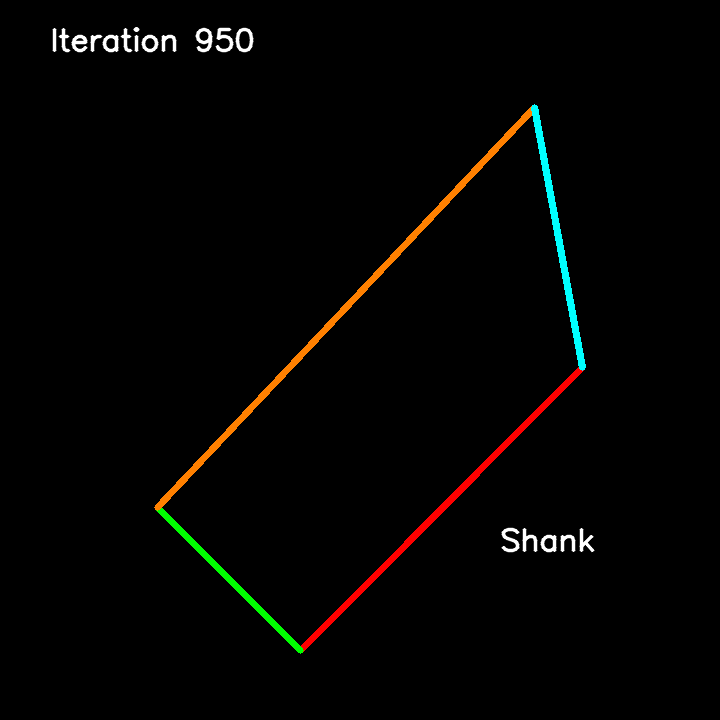

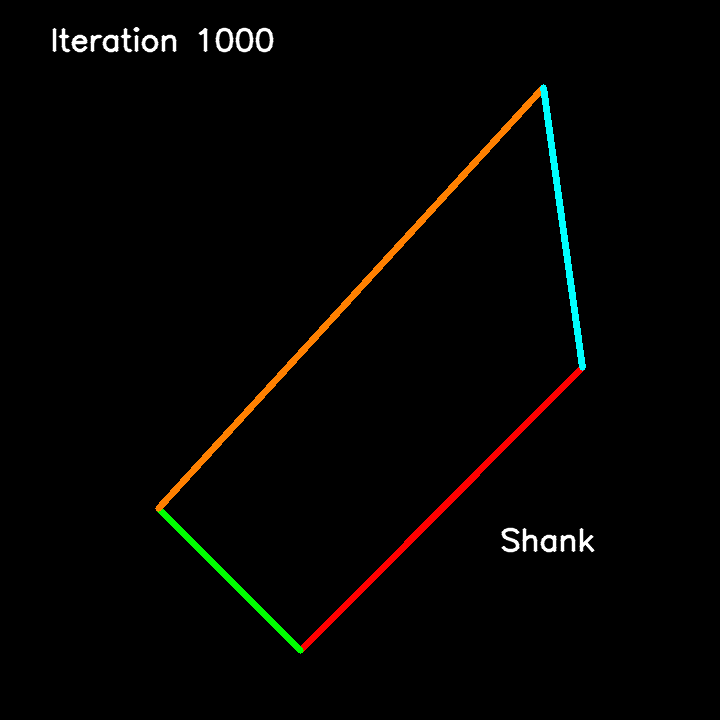

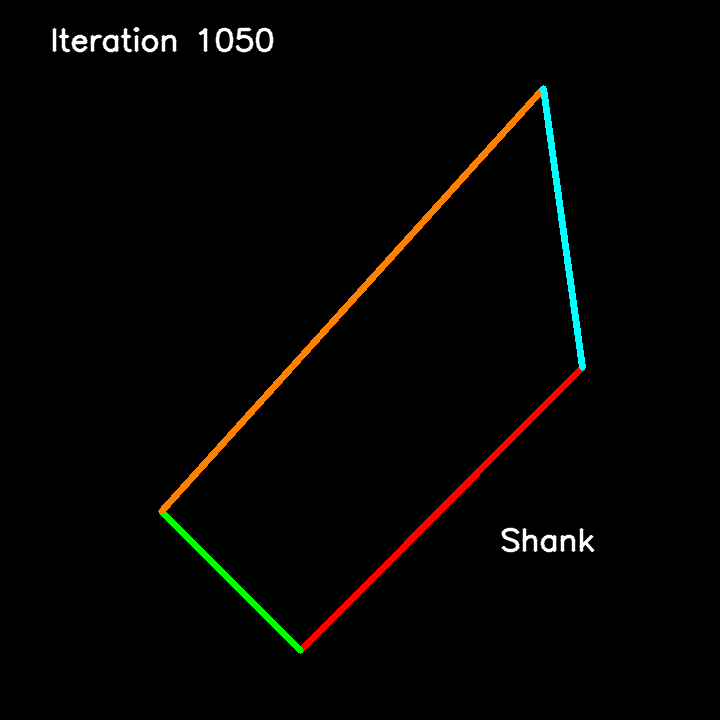

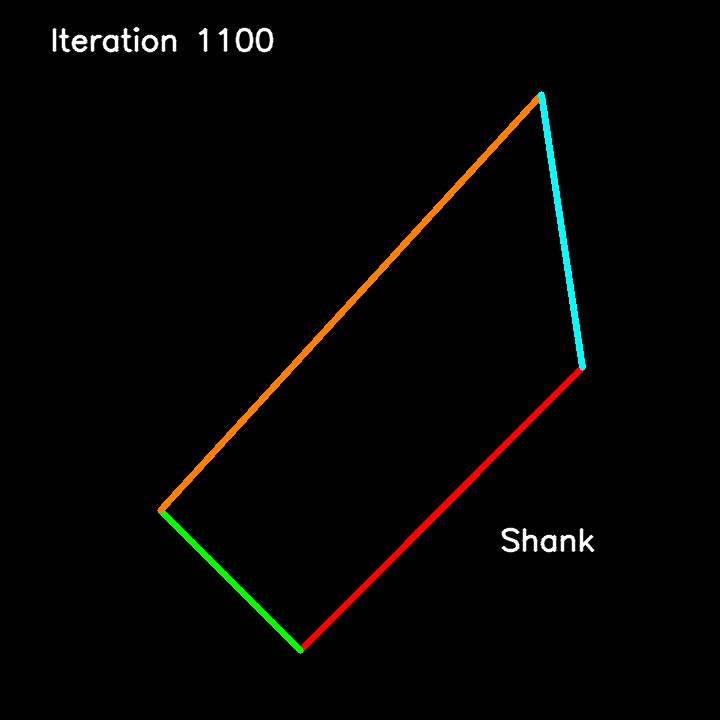

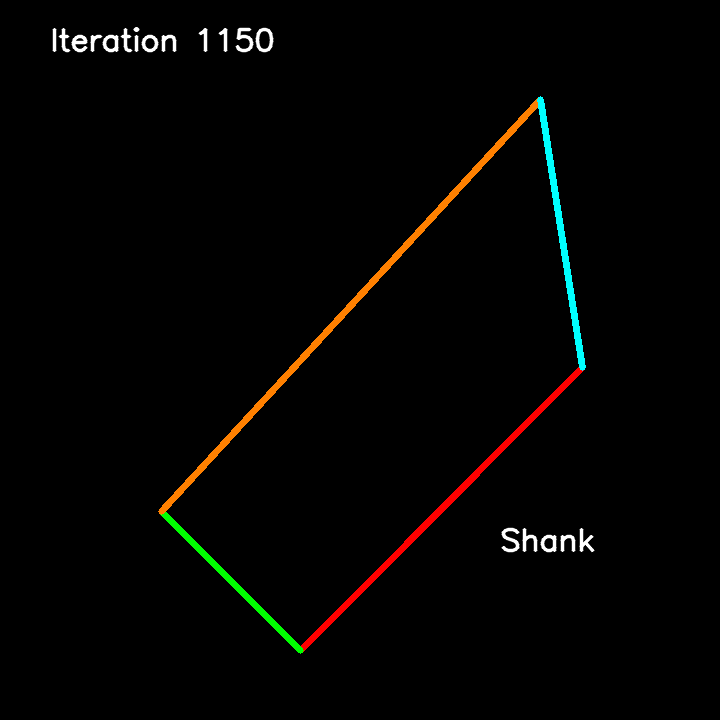

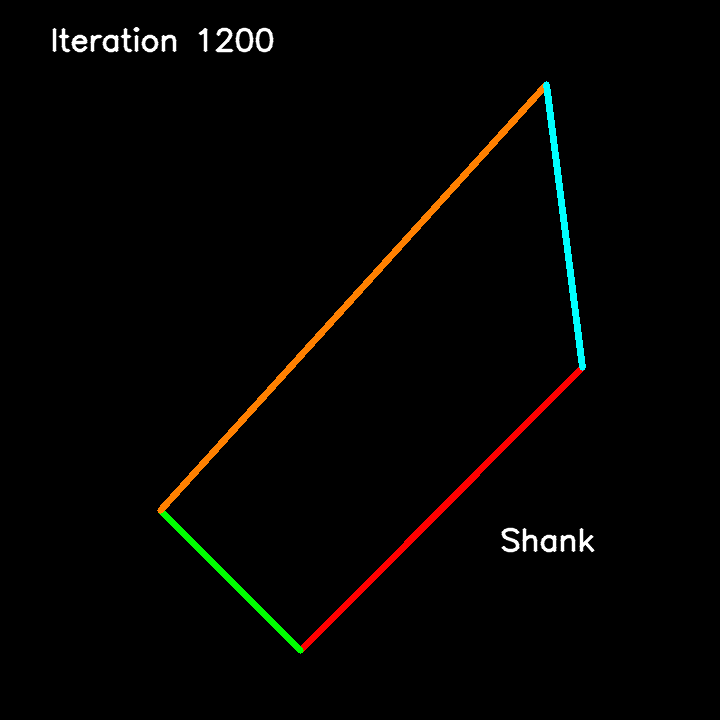

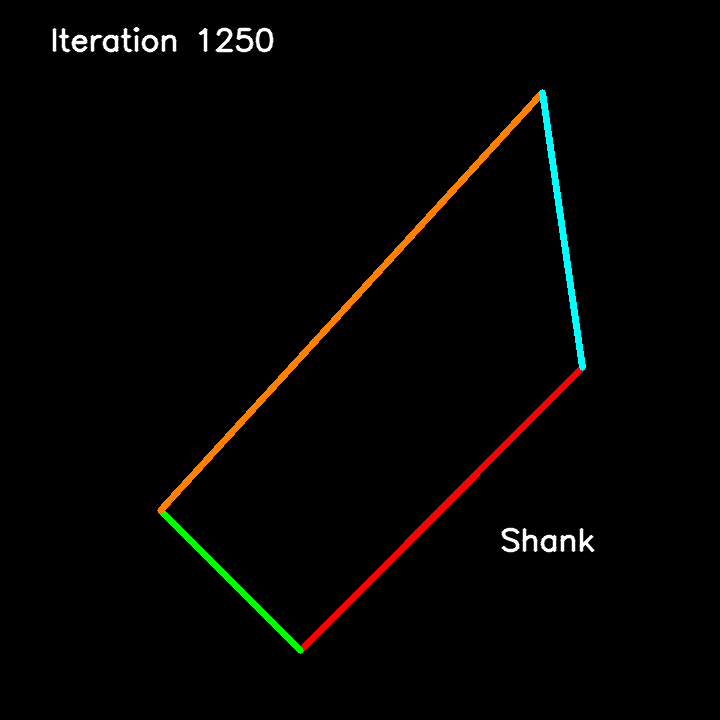

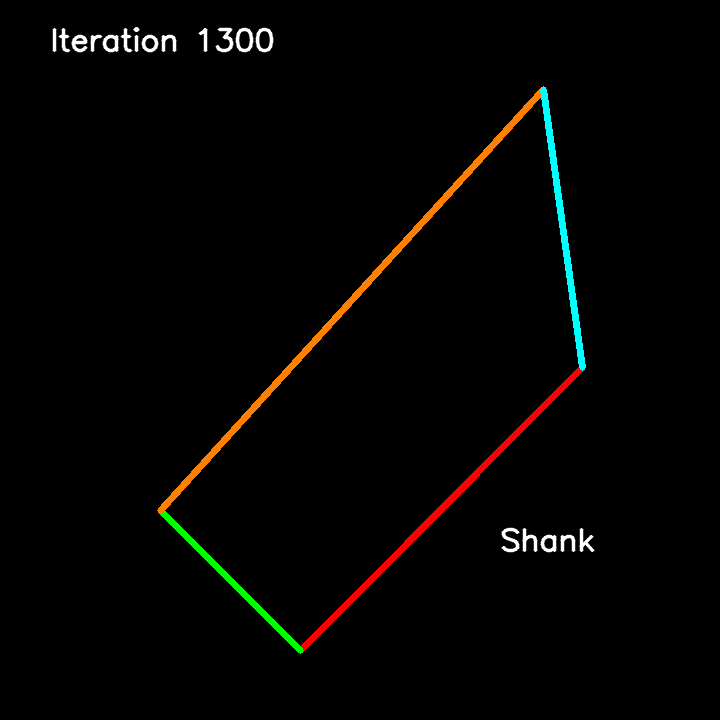

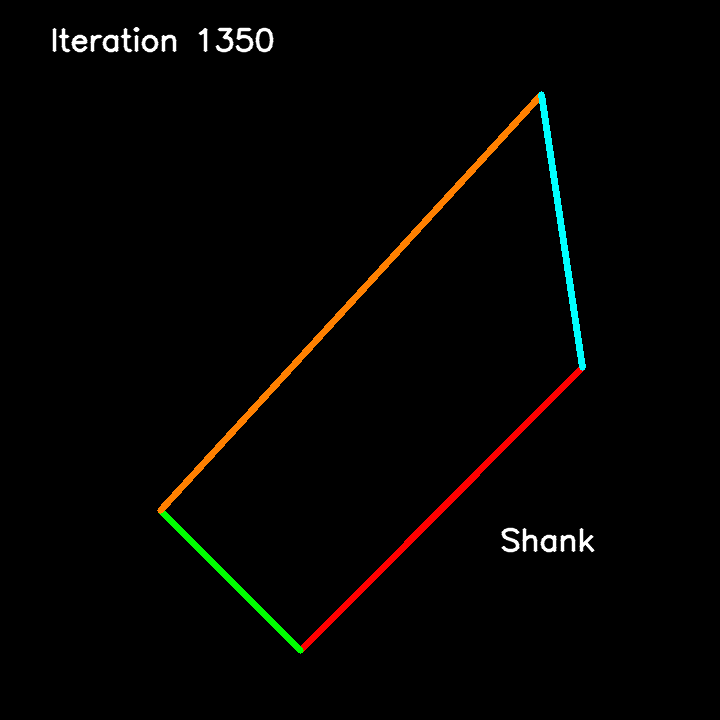

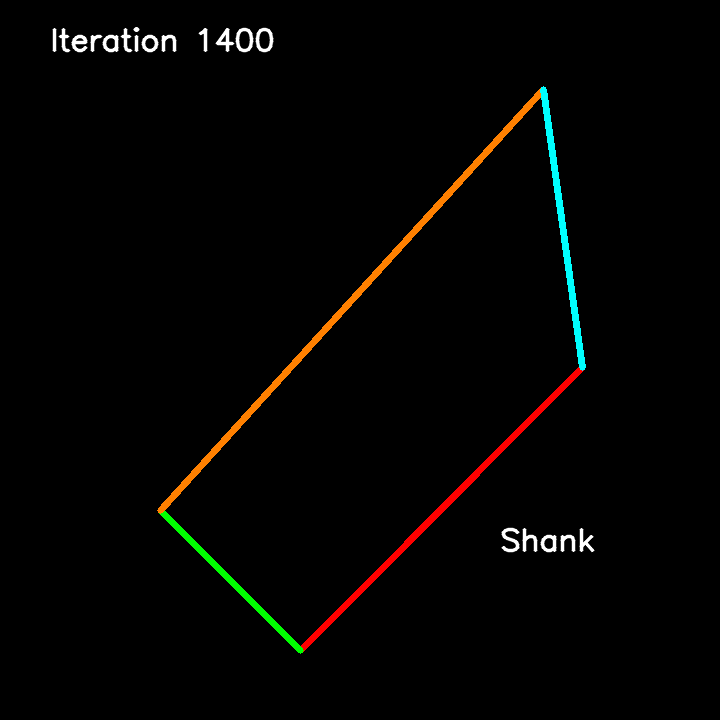

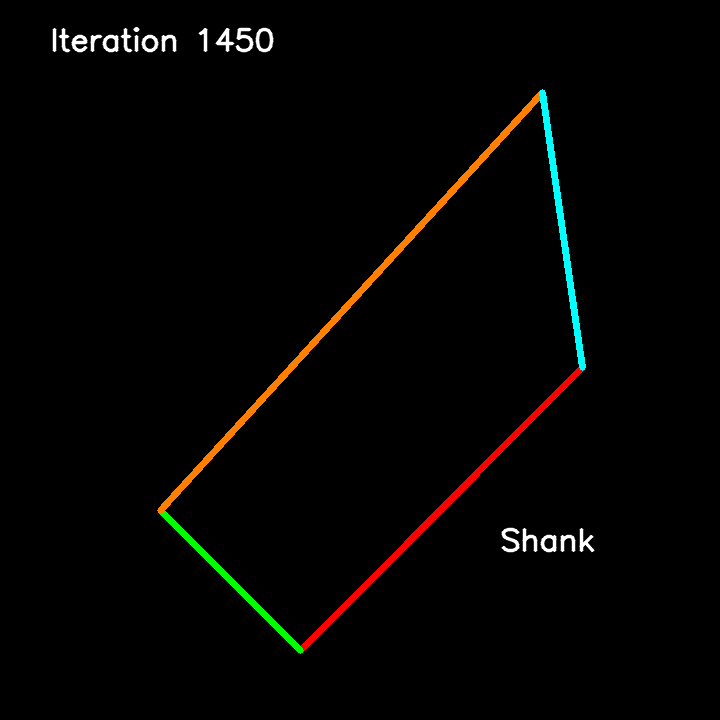

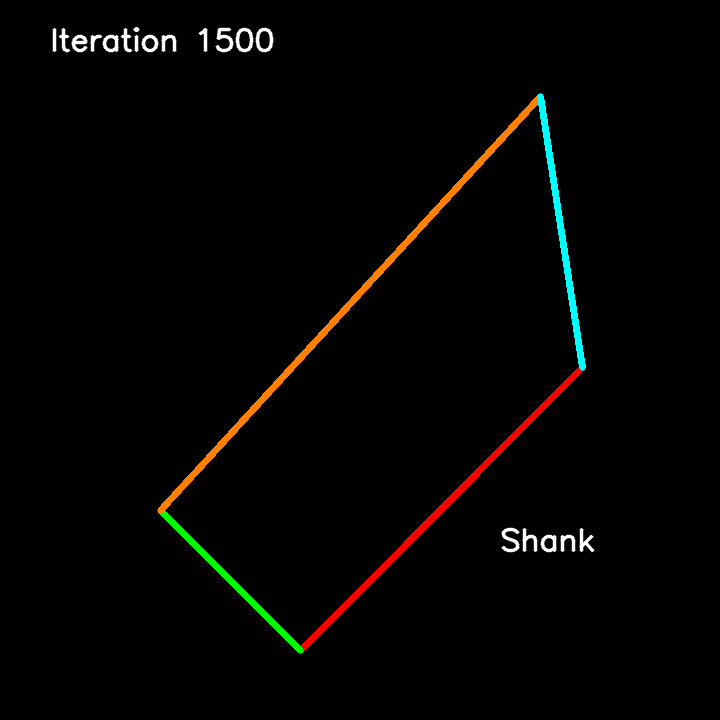

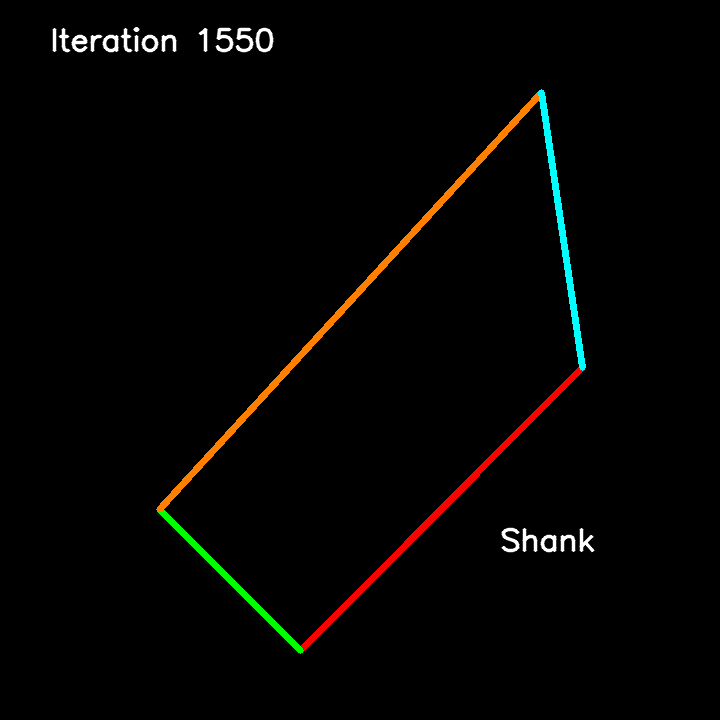

In [106]:
import cv2
import numpy as np
import pandas as pd
import math
from google.colab.patches import cv2_imshow

def draw(N, L, R, theta = 3*np.pi/4):
    
    phi = math.atan2((-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) - H * (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) * math.sqrt(2) / 4 + N * (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) * math.cos(theta) / 2 + H ** 2 + L ** 2 + N ** 2 - R ** 2) / L / (H * math.sqrt(2) - 2 * N * math.sin(theta)), (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) / L / 4)
    psi = math.atan2((-2 * N ** 2 * math.sin(theta) ** 2 * math.sqrt(2) + N * math.sqrt(2) * (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) * math.cos(theta) / 2 + 2 * H * N * math.sin(theta) - 2 * H * N * math.cos(theta) + L ** 2 * math.sqrt(2) + N ** 2 * math.sqrt(2) - R ** 2 * math.sqrt(2) - H * (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) / 2) / R / (H - math.sqrt(2) * N * math.sin(theta)), -(H * math.sqrt(2) - 2 * N * math.cos(theta) - (-2 * H * N ** 2 * math.sqrt(2) * math.sin(theta) ** 2 + 2 * H * N ** 2 * math.sqrt(2) * math.cos(theta) * math.sin(theta) + H ** 3 * math.sqrt(2) - 2 * H ** 2 * N * math.sin(theta) - 4 * H ** 2 * N * math.cos(theta) + H * L ** 2 * math.sqrt(2) + 3 * H * N ** 2 * math.sqrt(2) - H * math.sqrt(2) * R ** 2 - 2 * L ** 2 * N * math.cos(theta) - 2 * N ** 3 * math.cos(theta) + 2 * N * math.cos(theta) * R ** 2 - math.sqrt(-8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) * R ** 2 + 8 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 * R ** 2 - 8 * H * L ** 2 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 2 * H ** 6 - 4 * N ** 6 - 8 * H ** 4 * N ** 2 + 4 * H ** 4 * R ** 2 - 2 * H ** 2 * L ** 4 - 2 * H ** 2 * N ** 4 - 2 * H ** 2 * R ** 4 - 4 * L ** 4 * N ** 2 - 8 * L ** 2 * N ** 4 + 8 * N ** 4 * R ** 2 - 4 * N ** 2 * R ** 4 + 4 * H ** 4 * L ** 2 + 4 * N ** 6 * math.cos(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) ** 3 * math.cos(theta) + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 2 * math.cos(theta) ** 2 - 24 * H ** 4 * N ** 2 * math.sin(theta) * math.cos(theta) + 8 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 24 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) ** 2 - 16 * H ** 2 * N ** 4 * math.sin(theta) * math.cos(theta) + 24 * H ** 2 * N ** 2 * math.sin(theta) ** 2 * R ** 2 + 8 * H ** 5 * N * math.sqrt(2) * math.sin(theta) + 4 * H ** 5 * N * math.sqrt(2) * math.cos(theta) + 20 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) + 4 * H ** 3 * N ** 3 * math.sqrt(2) * math.cos(theta) + 12 * H * N ** 5 * math.sqrt(2) * math.sin(theta) - 8 * L ** 2 * N ** 2 * math.cos(theta) ** 2 * R ** 2 + 4 * L ** 4 * N ** 2 * math.cos(theta) ** 2 + 16 * L ** 2 * N ** 4 * math.sin(theta) ** 2 + 8 * L ** 2 * N ** 4 * math.cos(theta) ** 2 - 8 * N ** 4 * math.cos(theta) ** 2 * R ** 2 + 4 * N ** 2 * math.cos(theta) ** 2 * R ** 4 + 4 * H ** 2 * L ** 2 * N ** 2 + 4 * H ** 2 * L ** 2 * R ** 2 + 4 * H ** 2 * N ** 2 * R ** 2 + 8 * L ** 2 * N ** 2 * R ** 2 + 8 * H ** 2 * N ** 4 * math.sin(theta) ** 4 - 20 * H ** 4 * N ** 2 * math.sin(theta) ** 2 - 40 * H ** 2 * N ** 4 * math.sin(theta) ** 2 + 24 * H ** 3 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) + 16 * H ** 2 * L ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) + 16 * H ** 2 * N ** 2 * math.sin(theta) * math.cos(theta) * R ** 2 - 16 * H * L ** 2 * N ** 3 * math.sqrt(2) * math.sin(theta) ** 3 + 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) ** 2 * math.cos(theta) - 8 * H * N ** 5 * math.sqrt(2) * math.sin(theta) * math.cos(theta) ** 2 - 12 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.sin(theta) - 4 * H ** 3 * L ** 2 * N * math.sqrt(2) * math.cos(theta) - 12 * H ** 3 * N * math.sqrt(2) * math.sin(theta) * R ** 2 - 4 * H ** 3 * N * math.sqrt(2) * math.cos(theta) * R ** 2 + 4 * H * L ** 4 * N * math.sqrt(2) * math.sin(theta) - 16 * H * N ** 3 * math.sqrt(2) * math.sin(theta) * R ** 2 + 4 * H * N * math.sqrt(2) * math.sin(theta) * R ** 4)) / (-H * N * math.sin(theta) * math.sqrt(2) - H * N * math.sqrt(2) * math.cos(theta) + H ** 2 + N ** 2) / 2) / R)     

    return phi, psi

out = cv2.VideoWriter('GA_Progress.avi',  cv2.VideoWriter_fourcc(*'MJPG'), 20, (720,720)) # 20.0 frames per second
font = cv2.FONT_HERSHEY_SIMPLEX

"""
link_hist = pd.read_excel("link.csv", header=None)

link = training_data_x.as_matrix()"""

link = hist

for index in range(link.shape[0]):
    H = 0.2 * 2000
    N = link[index,0] * 2000
    L = link[index,1] * 2000
    R = link[index,2] * 2000
    theta = 3 * np.pi / 4
    try:
        phi , psi = draw(N, L, R, theta)
    except:
        continue
    frame = np.zeros((720,720,3), np.uint8)
    start1 = 300
    start2 = 650
    cv2.line(frame, (start1, start2),   #Draw Shank
            (int(start1 + H * np.cos(np.pi/4)), int(start2 - H * np.sin(np.pi/4))),
            (0,0,255),5) 
    cv2.putText(frame,'Shank',(500,550), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(frame,'Iteration ' + str(index),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.line(frame,(start1, start2),    # Draw N
            ((int(start1 + N * np.cos(theta)), int(start2 - N * np.sin(theta)))),
            (0,255,0),5)
    cv2.line(frame,((int(start1 + N * np.cos(theta)), int(start2 - N * np.sin(theta)))),    # Draw L
            (int(start1 + N * np.cos(theta) + L * np.cos(phi)),int(start2 - N * np.sin(theta) - L * np.sin(psi))),
            (0,128,255),5) 
    cv2.line(frame,(int(start1 + H * np.cos(np.pi/4)), int(start2 - H * np.sin(np.pi/4))),    # Draw R
            (int(start1 + N * np.cos(theta) + L * np.cos(phi)),int(start2 - N * np.sin(theta) - L * np.sin(psi))),
            (255,255,0),5)     
    out.write(frame) 
    if index % 50 == 0:
        cv2_imshow(frame)
out.release()
